<a href="https://colab.research.google.com/github/XU2024/lab-analysis-5/blob/main/Last_of_LabAnalysis5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial library includes and installations
run once - does not require you to edit anything

In [40]:
!pip install munch
import json
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from munch import munchify
import scipy.stats
from sklearn import linear_model, datasets



#Function definitions and constants
Run once - does not require you to edit anything

These functions are provided for you - see function definitions and comments for more information on their return values and usage

  1. `loadDataSet(filename)` - loads an individual .json file and checks it for really large jumps in major axis angle, which would indicate a problem with the fits
  1. `loadAllDataSets(startdir)` - loads all json files in a directory
  1. `meanOverTime(t,y,deltat)` - breaks data up into chunks about delta t long and calculates the average value of y over each chunk by integrating y and dividing by the total time
  1. `integralOverTime(t,y,deltat)` - like `meanOverTime`, but doesn't divide by the total time
  1. `sumOverTimeRange (t, y, deltat)` - like `integralOverTime`, but sums all values instead of integrating (no $dt$ term)
  1. `rateOfChange (t,y)` - calculates dy/dt (assumes t is monotonically increasing)
  1. `rateOfChangeAngular (t,theta)` - calculates dtheta/dt, taking into account wrapping every 2$\pi$ (assumes t is monotonically increasing and theta is in **radians**)
  1. `(m,b,m_e,b_e) = fitLine(x,y)` - least squares fit to $y = (m\pm m_e)x + b\pm b_e$ $m_e$ and $b_e$ are the uncertainties (errors) in the estimates of $m$ and $b$
  1. `(m,m_e) = fitLineThroughZero(x,y)`: like fitLine, but with b fixed to 0
  1. `fitLineRansac(x,y)` - least squares fit to y = m x + b , discarding outliers - note that this function returns extra values besides m, b, m_e nd b_e: inlying and outlying points : uses [RANSAC](https://https://en.wikipedia.org/wiki/Random_sample_consensus) to find outliers
  1. `fitLineHuber(x,y)` - least squares fit to y = m x + b , discarding outliers - note that this function returns extra values besides m, b, m_e nd b_e: inlying and outlying points : uses [Huber](https://scikit-learn.org/stable/modules/linear_model.html#huber-regression) to find outliers

        

In [41]:
gaccel = 9.802

nyc_latitude =40.730610
deghr = np.rad2deg(3600)
omega_foucault = -15*np.sin(np.deg2rad(nyc_latitude))/deghr


MAJAXIS = 0
MINAXIS = 1
THETA = 2
DPHI = 3
MAGROT = 4
MAGROTRATE =5


#loads one data set (work from one lab group stored in a .json file)
#data can be accessed as either a dictionary or a structure
#ie dataset["fits"] and dataset.fits are the same thing
#setupNumber: number on the wall
#section: 1-4 which section data came from
#thetaWall: angle of a line parallel to the wall
#z0: calibrated magnet height
#filename: name of the json file
#fits: list of fits to individual trials
#   anglePath: path to angle data file
#   magPath: path to magnetometer data file
#   offset: (x,y) calculated offset of the magnetometer from 0
#   tiltAngle: calculated angle the magnet was tilted away from z-axis
#   L: calculated length of the string (from period)
#   B0: best estimate of magnetic field strength z0 away directly along magnet axis
#   t: time each orbit started: (N,)
#   orbit: fit parameters for each orbit (N,6)
# >>    orbit[:,MAJAXIS] is the major axis size (in meters) <<<
# >>    orbit[:,MINAXIS] is the minor axis size (in meters) <<<
# >>    orbit[:,THETA] is the major axis angle <<<
#       orbit[:,DPHI] is the phase offset
#       orbit[:,MAGROT] is the orientation of the magnet tilt relative to the x-axis
#       orbit[:,MAGROTRATE] is the rate the bob was spinning about its axis per period


def loadDataSet(filename):
  file = open(filename,'r')
  results = json.load(file)
  file.close
  dataset = munchify(results) #can be accessed as a structure or a dict
  dataset.filename = filename
  valid = []
  for f in dataset.fits:
    f.offset = np.array(f.offset)
    f.orbit = np.array(f.orbit)
    f.t = np.array(f.t) 
    f.pulseEnergy = np.array(f.pulseEnergy)
    f.pulsePhase = np.array(f.pulsePhase)
    dp = np.diff(np.unwrap(f.orbit[:,THETA]))
    valid.append((np.abs(dp) < np.pi/4).all()) #extremely large jump from one swing to the next - bad fit
  bad = np.array(valid) == False
  if (bad.any()):
    print('{}: bad fits found in experiments {}'.format(filename, np.where(bad)[0]))
    dataset.fits = [dataset.fits[i] for i in np.where(valid)[0]]
  return dataset

def loadAllDataSets(startdir):
  files = sorted(glob.glob(startdir + '/*.json'))
  data = []
  for f in files:
    d = loadDataSet(f)
    if len(d.fits) > 0:
      data.append(d)
  return data
#  return [loadDataSet(f) for f in files]

#my = meanOverTime (t,y,deltat)
#calculates the mean value of y and dy/dt at approximate intervals of deltat
#   e.g. if deltat is 10, then my[0] is the average value of y between 
#   t[0] and t[0] + 10
#detalt is adjusted downward to evenly divide the whole range
#   e.g. if deltat is 100 and t ranges from 0 to 110 seconds, then delta t will be 55
def meanOverTime (t, y, deltat):
  numpts = int(np.ceil((t[-1]-t[0])/deltat)) + 1
  inds = np.linspace(0,len(t),numpts, endpoint=False, dtype=int)
  dt = np.gradient(t)
  my = np.diff((np.cumsum(y*dt))[inds])/np.diff(t[inds])
  return my

def integralOverTime (t, y, deltat):
  numpts = int(np.ceil((t[-1]-t[0])/deltat)) + 1
  inds = np.linspace(0,len(t),numpts, endpoint=False, dtype=int)
  dt = np.gradient(t)
  iy = np.diff((np.cumsum(y*dt))[inds])
  return iy
def sumOverTimeRange (t, y, deltat):
  numpts = int(np.ceil((t[-1]-t[0])/deltat)) + 1
  inds = np.linspace(0,len(t),numpts, endpoint=False, dtype=int)
  dt = np.gradient(t)
  sy = np.diff((np.cumsum(y))[inds])
  return sy
#dy_dt = rateOfChange(t,y)  
def rateOfChange (t,y):
  return np.gradient(y)/np.gradient(t)

#dtheta_dt = rateOfChangeAngular(theta)
#unwraps theta so that there aren't any jumps bigger than pi before taking derivative
def rateOfChangeAngular(t,theta):
  return np.gradient(np.unwrap(theta))/np.gradient(t)

#(m,b,m_e,b_e) = fitLine(x,y)
#least squares fit to y = m x + b : m_e,b_e are uncertainties in m,b
def fitLine(x,y):
  p = np.polyfit(x,y,1)
  res = y - p[0]*x - p[1]
  m_e = np.sqrt(np.var(res)/np.sum((x-np.mean(x))**2))
  b_e = np.sqrt(np.mean(x**2))*m_e
  return (p[0],p[1],m_e,b_e)

def fitLineThroughZero(x,y):
  m = np.sum(x*y)/np.sum(x**2)
  res = y - m*x
  m_e = np.sqrt(np.var(res)/np.sum((x-np.mean(x))**2))
  return (m,m_e)

def fitLineHuber(x,y,epsilon=2):
  huber = linear_model.HuberRegressor(epsilon=epsilon)
  huber.fit(x.reshape(-1,1),y)
  outlier_mask = huber.outliers_
  inlier_mask = np.logical_not(outlier_mask)
  (m,b,me,be) = fitLine(x[inlier_mask], y[inlier_mask])
  xi = x[inlier_mask]
  yi = y[inlier_mask]
  xo = x[outlier_mask]
  yo = y[outlier_mask]
  return (m,b,me,be,xi,yi,xo,yo)

#((m,b,me,be,xi,yi,xo,yo) = fitLineRansac(x,y)
#least squares fit to y = m x + b , discarding outliers
#xi,yi are x,y values used (inliers) 
#xo.yo are x,y values discarded (outliers)
def fitLineRansac(x,y):
  #print(np.median(np.abs(y - np.median(y))))
  ransac = linear_model.RANSACRegressor()
  ransac.fit(x.reshape(-1,1),y.reshape(-1,1))
  inlier_mask = ransac.inlier_mask_
  res = y[inlier_mask]-ransac.predict(x.reshape(-1,1))[inlier_mask,0]
  ransac.residual_threshold = np.median(np.abs(res))
  ransac.fit(x.reshape(-1,1),y.reshape(-1,1))

  ransac.stop_probability = 1
  ransac.max_trials = 10000
  ransac.min_samples = 0.1
  res = y[inlier_mask]-ransac.predict(x.reshape(-1,1))[inlier_mask,0]
  ransac.residual_threshold = 2.5*np.std(res)
  ransac.fit(x.reshape(-1,1),y.reshape(-1,1))
  inlier_mask = ransac.inlier_mask_
  
  # res = y[inlier_mask]-ransac.predict(x.reshape(-1,1))[inlier_mask,0]
  # ransac.residual_threshold = np.median(np.abs(res))
  # ransac.fit(x.reshape(-1,1),y.reshape(-1,1))
  # inlier_mask = ransac.inlier_mask_

  outlier_mask = np.logical_not(inlier_mask)
  (m,b,me,be) = fitLine(x[inlier_mask], y[inlier_mask])
  xi = x[inlier_mask]
  yi = y[inlier_mask]
  xo = x[outlier_mask]
  yo = y[outlier_mask]
  print(ransac.n_trials_)
  return (m,b,me,be,xi,yi,xo,yo)

#Fetch and load the data to be analyzed
run once



`alldata` contains everyone's data - each element of this list is one dataset


## fields in dataset structure
- `setupNumber`: number on the wall
- `section`: 1-4 which section data came from
- `thetaWall`: angle of a line parallel to the wall
- `z0`: calibrated magnet height
- `filename`: name of the json file
- `fits`: list of fits to individual trials
   - `anglePath`: path to angle data file
   - `magPath`: path to magnetometer data file
   - `offset`: (x,y) calculated offset of the magnetometer from 0
   - `tiltAngle`: calculated angle the magnet was tilted away from z-axis
   - `L`: calculated length of the string (from period)
   - `B0`: best estimate of magnetic field strength z0 away directly along magnet axis
   - `t`: time each orbit started: (N,)
   - `pulseEnergy`: energy added to the bob by action of the drive (generally from 2 pulses per cycle)
   - `pulsePhase`: average phase (mod $\pi$) at which the pulses were delivered - note that it's in radians
   - `orbit`: fit parameters for each orbit (N,6)
        - `orbit[:,MAJAXIS]` is the **major axis** size (in meters) 
        - `orbit[:,MINAXIS]` is the **minor axis** size (in meters) 
        - `orbit[:,THETA]` is the **angle of the major axis** 
        - `orbit[:,DPHI]` is the phase offset
        - `orbit[:,MAGROT]` is the orientation of the magnet tilt relative to the x-axis
        - `orbit[:,MAGROTRATE]` is the rate the bob was spinning about its axis per period
    

In [42]:
!rm -rf data/
!git clone https://github.com/NYUExperimentalPhysics1-2021/lab5-shared-data-whole-class data
alldata = loadAllDataSets('/content/data/')

Cloning into 'data'...
remote: Enumerating objects: 117, done.
remote: Total 117 (delta 0), reused 0 (delta 0), pack-reused 117
Receiving objects: 100% (117/117), 3.68 MiB | 5.77 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/data/section1setup7-22-Nov-2021 (1).json: bad fits found in experiments [6]
/content/data/section1setup7-22-Nov-2021.json: bad fits found in experiments [2 3 4]
/content/data/section2setup9-23-Nov-2021.json: bad fits found in experiments [ 8 11 14]


##Goal of this analysis
The predicted rotation due to driving the pendulum is given by

$\Delta \theta = -\frac{ab}{a^2-b^2}\frac{\Delta U}{U}f(\phi) \approx -\frac{b}{a}\frac{\Delta U}{U}f(\phi) $, with 

$f(\phi) = \cot(2\phi)$ (my formula)

or

$f(\phi) = \frac{{\pi}/{2} - \phi}{4 \tan(\phi)}$ (Schumacher and Tarbet)

For a given interval of time, call $\Delta \theta_{meas} = \theta_{final} - (\theta_{initial} + \int \Omega_{pred}(t)dt)$, where $\Omega_{pred} = \frac{3}{8}\omega \frac{ab}{L^2} - 9.8^\circ/hr$ is the predicted rotation due to the elliptical orbit and the rotation of the earth.

Then both models predict a graph of $\Delta \theta_{meas}$ vs. $\sum_{pulses}(-\frac{b}{a}\frac{\Delta U}{U})$ will show a linear relation with an intercept of 0 and different slopes, depending on the phase. Crucially, my model predicts that the slope will be positive for $\phi < 45^\circ$ and negative for $\phi > 45^\circ$, which Schumacher and Tarbet predict the slope will always be positive. 

So our goal is, first, for intervals of time set by `deltat`, 

1. Calculate $\Delta \theta_{meas} = \theta_{final} - (\theta_{initial} + \int \Omega_{pred}(t)dt) = \int \left((\frac{d \theta}{d t})_{meas} - \Omega_{pred}(t)\right)dt$
2. Calculate a "rotation factor:" $\sum_{pulses}(-\frac{b}{a}\frac{\Delta U}{U})$ for the same interval
3. Calculate the mean $\phi$ of the drive for that interval

Then use this information and sort each interval by the drive phase. 
1. For each phase, make a plot of $\Delta \theta_{meas}$ vs. $R$, the "rotation factor" - does the sign of the slope vs. phase match either model's predictions?
1. For each phase calculate the best fit to  $\Delta \theta_{meas} = m(\phi) R$
1. Plot $m(\phi)$ vs. $\phi$ and compare to model predictions


###Let's break it down


First, for intervals of time set by `deltat`, 

1. Calculate $\Delta \theta_{meas} = \theta_{final} - (\theta_{initial} + \int \Omega_{pred}(t)dt) = \int \left((\frac{d \theta}{d t})_{meas} - \Omega_{pred}(t)\right)dt$
2. Calculate a "rotation factor:" $\sum_{pulses}(-\frac{b}{a}\frac{\Delta U}{U})$ for the same interval
3. Calculate the mean $\phi$ of the drive for that interval

In the cell below:

1. Define `deltat = 100`, the time interval which you can adjust (rerun subsequent code after adjusting)
1. Create empty lists, `deltatheta, rotfactor, pulsephase`
1. Loop over all data in alldata `for data in alldata:`
  1. get the mass of the bob (`m = data.mass`)
  1. Loop over all fits in data (`for f in data.fits`)
  1. Calculate or extract from the data structure `f`: `L, omega, a, t, b, theta, du, u, phipulse`  -  for example: 
  ```
    L = f.L
    omega = np.sqrt(gaccel/f.L)
    a = f.orbit[:,MAJAXIS]
    du = f.pulseEnergy
  ```
  1. Calculate the predicted rotation `rp` = $.375 \omega \frac{ab}{L^2} + \Omega_{foucault}$ note that $\Omega_{foucault}$ is defined in radians/sec already as `omega_foucault`
  1. Calculate the actual rate of change `dtheta_dt` using `rateOfChangeAngular`
  1. Integrate the difference between measured and predicted rotations (`dtheta_dt - rp`) using `integralOverTime`. Append these integrals to `deltatheta`
  1. Calculate the predicted rotation factor per cycle `rf` as $-\frac{b}{a}\frac{\Delta U}{U}$
  1. Sum the predicted rotation factors using `sumOverTimeRange` (`integralOverTime` includes a factor of $dt$ and `sumOverTimeRange` does not). Append these sums to `rotfactor`
  1. Calculate the mean drive phase for each interval using `meanOverTime`; append these to `pulsephase`

In [43]:
## your code here
deltat=100
deltatheta=[]
rotfactor=[]
pulsephase=[]
for data in alldata:
  m=data.mass
 
  for f in data.fits:
    L=f.L
    t=f.t
    w=np.sqrt(gaccel/f.L)
    a=f.orbit[:,MAJAXIS]
    b=f.orbit[:,MINAXIS]
    theta=f.orbit[:,THETA]
    du=f.pulseEnergy
    u=(m*(a**2)*(w**2))*0.5
    phipulse=f.pulsePhase
    
    rp=0.375*w*(a*b)/L**2+omega_foucault ## predicted
    dtheta_dt = rateOfChangeAngular(t, theta)
    deltatheta.append(integralOverTime(t, dtheta_dt-rp, deltat))
    rf=-(b*du)/(a*u)
    rotfactor.append(sumOverTimeRange(t, rf, deltat))
    pulsephase.append(meanOverTime(t, phipulse,deltat))

###Now let's analyze the intervals. 

First, if a fit was really wonky, something was wrong in the data collection, you might get a huge value for the predicted rotation factor. Let's take care of that by using numpy's ability to do "logical slicing"

1. Convert all your lists (`deltatheta`, `rotfactor`, `pulsephase`) to 1D numpy arrays. `deltatheta = np.concatenate(deltatheta)` etc. 
2. Define a numpy logical array `valid` that's equal to $|$ `rotfactor` $| < \pi$
3. For each array, select only the `valid` parts. `deltatheta = deltatheta[valid]` etc.

Next let's define a set of phases to examine. We didn't evenly cover all phases in the class (at least not of this writing), so we shouldn't use `np.arange`. 
1. So let's use `pset = (20,25,30, 35, 45, 50, 60)`
1. create empty lists, `slope` and `slope_eb` to hold the fit results

Now iterate over the phases: `for phase in pset:`
1. Define a numpy logical array `valid` that's equal to $|$ `np.rad2deg(pulsephase) - phase` $| < 2.5$
2. Make a scatter plot of `np.deg2rad(dtheta[valid])` (on the y-axis) vs `np.deg2rad(rotfactor[valid])` on the x-axis
3. Fit the line `dtheta[valid] = m * rotfactor[valid]` using `(m,me) = fitLineThroughZero(...)`
4. Append the slope (`m`) to `slope` and the slope error bar (`me`) to `slope_eb`
5. Plot a black dashed line that goes through 0 with slope `m`
6. Plot a magenta dashed line that goes through 0 with slope $1/\tan(2\phi)$ (be sure to convert $\phi$ to radians)
7. Plot a blue dahsed line that goes through 0 with slope $\frac{{\pi}/{2} - \phi}{4 \tan(\phi)}$ (be sure to convert $\phi$ to radians)
1. Title the graph with "phase = (the phase)"
1. set the y-axis label to "$\Delta \theta$ (deg, measured)"
1. set the x-axis label to "rotation factor (deg)"
8. call `plt.show()` to move on to the next graph

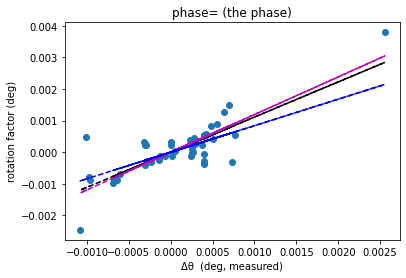

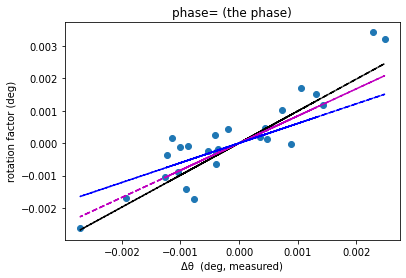

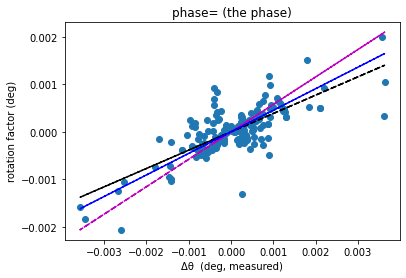

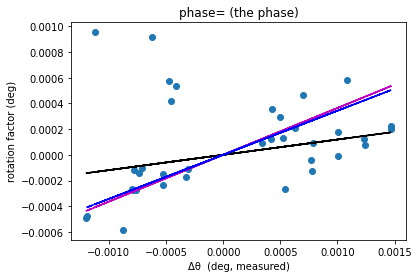

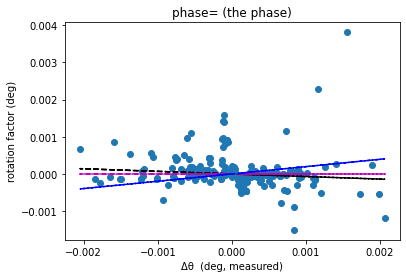

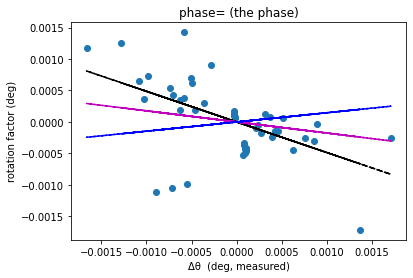

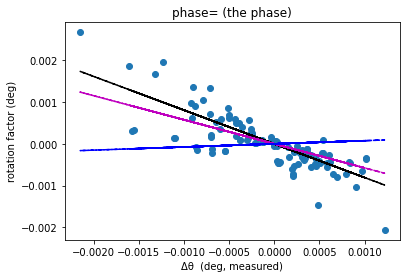

In [44]:
## your code here
deltatheta=np.concatenate(deltatheta)
rotfactor=np.concatenate(rotfactor)
pulsephase=np.concatenate(pulsephase)

valid=np.array(np.abs(rotfactor)<np.pi)
deltatheta=deltatheta[valid]
rotfactor=rotfactor[valid]
pulsephase=pulsephase[valid]

pset= (20, 25, 30, 35,45,50,60)
slope, slope_eb = [], []

for phase in pset:    ## Do not forget about this
  valid= np.array(np.abs(np.rad2deg(pulsephase)-phase)< 2.5)
  plt.scatter(np.deg2rad(rotfactor[valid]),np.deg2rad(deltatheta[valid]))
  (m,me) = fitLineThroughZero(np.deg2rad(rotfactor[valid]),np.deg2rad(deltatheta[valid])) ## Do not foregt about the brancket
  slope.append(m)
  slope_eb.append(me)

  plt.plot(np.deg2rad(rotfactor[valid]), m*np.deg2rad(rotfactor[valid]),'k--')

  slope0=1/np.tan(2*np.deg2rad(phase))
  plt.plot(np.deg2rad(rotfactor[valid]), slope0*np.deg2rad(rotfactor[valid]), 'm--')

  slope1=(np.pi/2-np.deg2rad(phase))/(4*np.tan(np.deg2rad(phase)))
  plt.plot(np.deg2rad(rotfactor[valid]), slope1*np.deg2rad(rotfactor[valid]), 'b--')

  plt.title("phase= (the phase)")
  plt.xlabel("Δθ  (deg, measured)")
  plt.ylabel("rotation factor (deg)")
  plt.show()


### Time for the final plot

Make an error plot of `slope` $\pm$ `slope_eb` vs. `pset`. Make round markers that aren't connected by lines

Overlay plots of $1/\tan(2\phi)$  vs. $\phi$ (`pset`) as a black dashed line and $\frac{{\pi}/{2} - \phi}{4 \tan(\phi)}$ vs. $\phi$ as a red dashed line. Make sure you do your calculations in radians. 

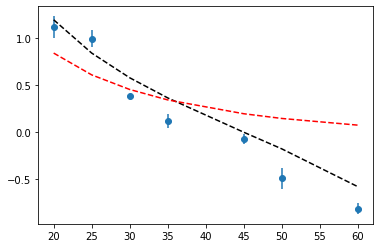

In [49]:
## your code here
plt.errorbar(pset, slope, yerr=slope_eb, marker='o', linestyle='None')
plt.plot(pset, 1/np.tan(2*np.deg2rad(pset)),'k--')  ## notice x variable is pset
slope2=(np.pi/2-np.deg2rad(pset))/(4*np.tan(np.deg2rad(pset)))
plt.plot(pset,slope2,'r--' )

#Questions

Explain why we compared $\int dt\left((\frac{d \theta}{dt}) - (.375 \omega \frac{ab}{L^2} + \Omega_{foucault})\right)$ to $\sum-\frac{b}{a}\frac{\Delta U}{U}$

Do the data support (or disprove) the following statements (explain)?

1. Applying the drive force rotates the orbit by an amount proportional to $-\frac{b}{a}\frac{\Delta U}{U}$

Yes. The black dashed line follows the trend of those points very accurately.


2. Applying the drive force rotates the orbit by $-\frac{b}{a}\frac{\Delta U}{U} \cot(2\phi)$

Yes. The magenta dashed line follows the trend accurately, too, almost same as the black line.

3.  Applying the drive force rotates the orbit by $-\frac{b}{a}\frac{\Delta U}{U} \frac{{\pi}/{2} - \phi}{4 \tan(\phi)}$

No.  The blue lines do nor accurately follow the trend so accurately. It is less accurate than the other 2.